<div style='background: linear-gradient(135deg, #0d0d1a 0%, #1a1a3e 50%, #0f3460 100%); padding: 40px; border-radius: 16px; text-align: center; margin-bottom: 20px;'>
  <h1 style='color: #00d4ff; font-size: 2.5em; margin: 0;'>🤖 Hand Gesture Classification — Deep Learning Edition</h1>
  <p style='color: #a8dadc; font-size: 1.2em; margin-top: 12px;'>MediaPipe Landmarks → PyTorch Neural Network</p>
  <hr style='border-color: #00d4ff; margin: 20px 0;'/>
  <p style='color: #ccc; margin: 0;'>
    <b style='color:#00d4ff'>Architecture:</b> MLP with BatchNorm · Dropout · ReLU
    &nbsp;|&nbsp;
    <b style='color:#00d4ff'>Framework:</b> PyTorch
  </p>
</div>

## 🧠 Problem Description & Deep Learning Perspective

### What is the problem?
We are solving a **multi-class classification** problem: given a single frame's 21 hand landmarks (each with x, y, z coordinates → **63 features**), predict which of **18 hand gestures** is being performed (call, fist, like, peace, etc.).

### What did we do in ML1 (Classical Approach)?
In the previous notebook we trained **Random Forest, Gradient Boosting, SVM (RBF & Linear), and KNN** directly on the raw 63 landmark coordinates. These models rely on **hand-crafted feature space geometry** and **kernel tricks** to separate classes.

### Why switch to Deep Learning?
| Aspect | Classical ML | Deep Learning (MLP) |
|---|---|---|
| Feature extraction | Manual / implicit via kernels | **Learned automatically** layer by layer |
| Scalability | Struggles with large data | Thrives with large datasets |
| Non-linearity | Limited (RBF kernel, tree splits) | **Unlimited** via activation functions |
| Representation | Flat, fixed | **Hierarchical** — each layer learns richer abstractions |
| Regularization | Pruning, C parameter | **Dropout, BatchNorm, Weight Decay** |

### Deep Learning Strategy
We build a **Multi-Layer Perceptron (MLP)** — the foundational feedforward neural network. Even though our input is tabular (not images), an MLP is powerful enough to:
1. Learn **non-linear interactions** between landmark coordinates (e.g., relative finger angles)
2. Automatically build an **internal representation** of gesture 'shape'
3. Scale to the full 25,675-sample dataset efficiently via **mini-batch gradient descent**

### Theory Checkpoint — Universal Approximation Theorem
> *A neural network with at least one hidden layer and a non-linear activation can approximate **any** continuous function to arbitrary precision.*

This means our MLP can learn the exact decision boundaries that separate all 18 gesture classes — something a single-kernel SVM fundamentally cannot do simultaneously.

## 📦 1 — Imports

In [2]:
# ── Core ──────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# ── Sklearn (only for preprocessing & evaluation helpers) ─────────────────────
# NOTE: We keep sklearn ONLY for utilities — no classical models are trained here.
#       All learning is done by the neural network.
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ── PyTorch ───────────────────────────────────────────────────────────────────
# PyTorch is our Deep Learning framework.
# torch.nn   → building blocks for neural network layers
# DataLoader → efficient mini-batch iteration (crucial for SGD-based training)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# ── Reproducibility ────────────────────────────────────────────────────────────
# Setting seeds ensures that weight initialization and data shuffling
# produce the same results on every run — essential for fair comparison.
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# ── Device (GPU if available, else CPU) ────────────────────────────────────────
# DL models benefit enormously from GPU parallelism. PyTorch abstracts
# hardware via the 'device' concept — the same code runs on CPU or GPU.
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'🖥️  Using device: {DEVICE}')

# ── Plotting style ─────────────────────────────────────────────────────────────
plt.rcParams.update({
    'figure.facecolor' : '#0f0f1a',
    'axes.facecolor'   : '#1a1a2e',
    'axes.edgecolor'   : '#444',
    'axes.labelcolor'  : '#ccc',
    'xtick.color'      : '#aaa',
    'ytick.color'      : '#aaa',
    'text.color'       : '#eee',
    'grid.color'       : '#333',
    'grid.linestyle'   : '--',
    'grid.alpha'       : 0.5,
})
PALETTE = ['#00d4ff','#e94560','#05c46b','#ffd460','#533483',
           '#f4a261','#2d6a4f','#457b9d','#a8dadc','#e76f51',
           '#d62828','#1d3557','#2a9d8f','#e9c46a','#264653',
           '#f77f00','#fcbf49','#e63946']

os.makedirs('models', exist_ok=True)
print('✅ All imports successful!')

🖥️  Using device: cuda
✅ All imports successful!


## 📂 2 — Load & Explore Data

In [3]:
# Load the same dataset used in ML1 — 21 MediaPipe landmarks per hand frame.
# Each landmark contributes (x, y, z) → 21 × 3 = 63 features + 1 label column.
df = pd.read_csv('hand_landmarks_data.csv')

print(f'Shape  : {df.shape}')
print(f'Labels : {sorted(df["label"].unique().tolist())}')
print(f'Nulls  : {df.isnull().sum().sum()}')
df.head(3)

Shape  : (25675, 64)
Labels : ['call', 'dislike', 'fist', 'four', 'like', 'mute', 'ok', 'one', 'palm', 'peace', 'peace_inverted', 'rock', 'stop', 'stop_inverted', 'three', 'three2', 'two_up', 'two_up_inverted']
Nulls  : 0


,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call


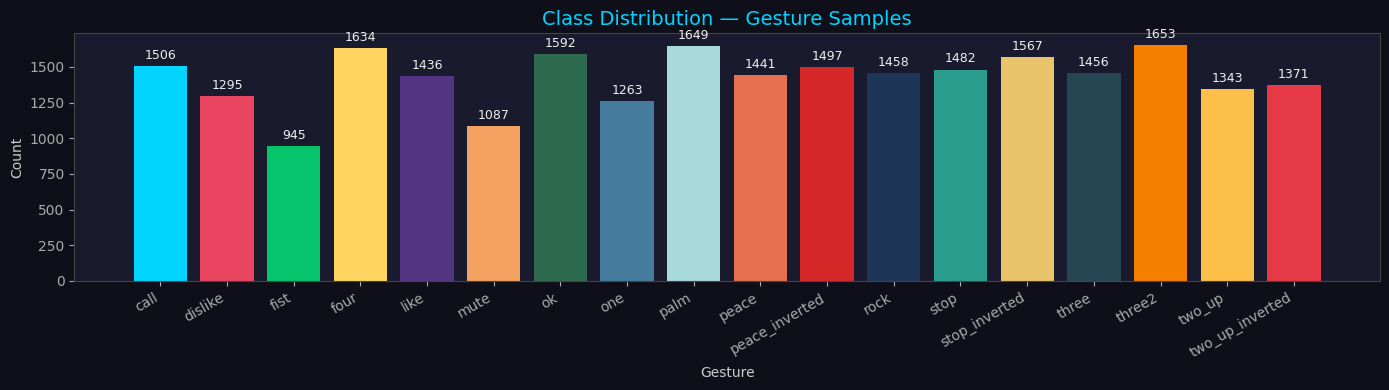

Min class: 945  |  Max class: 1653
Imbalance ratio: 1.7x


In [4]:
# ── Class Distribution ─────────────────────────────────────────────────────────
# Understanding class balance is critical before training.
# Imbalanced classes → the network can 'cheat' by predicting the majority class.
# We handle this with class weights in the loss function.
fig, ax = plt.subplots(figsize=(14, 4))
counts = df['label'].value_counts().sort_index()
bars = ax.bar(counts.index, counts.values, color=PALETTE[:len(counts)])
ax.bar_label(bars, fmt='%d', padding=3, color='#eee', fontsize=9)
ax.set_title('Class Distribution — Gesture Samples', color='#00d4ff', fontsize=14)
ax.set_xlabel('Gesture')
ax.set_ylabel('Count')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

print(f'Min class: {counts.min()}  |  Max class: {counts.max()}')
print(f'Imbalance ratio: {counts.max()/counts.min():.1f}x')

## ⚙️ 3 — Preprocessing

### Why preprocessing matters differently in DL vs Classical ML

- **StandardScaler** is even *more* important in deep learning than in classical ML. Without it, features with large magnitudes (e.g. pixel x-coordinates ~200–400) dominate gradients during backpropagation, causing training instability (vanishing/exploding gradients).
- **LabelEncoder → Integer Labels**: PyTorch's `CrossEntropyLoss` expects raw integer class indices (not one-hot), so `LabelEncoder` is all we need.
- **Train / Val / Test Split**: Unlike classical ML where we often just do train/test, in DL we need a **validation set** to monitor overfitting *during* training and trigger early stopping.

In [5]:
# ── Features & Labels ──────────────────────────────────────────────────────────
X = df.drop(columns=['label']).values.astype(np.float32)
y_raw = df['label'].values

# ── Label Encoding ─────────────────────────────────────────────────────────────
# Neural networks need numeric targets.
# LabelEncoder maps strings → integers: 'call'→0, 'dislike'→1, ...
le = LabelEncoder()
y  = le.fit_transform(y_raw).astype(np.int64)
NUM_CLASSES = len(le.classes_)
print(f'Classes ({NUM_CLASSES}): {list(le.classes_)}')

# ── Train / Validation / Test Split ────────────────────────────────────────────
# 70% train → model learns weights
# 15% val   → monitor overfitting & trigger early stopping (never touches test!)
# 15% test  → final unbiased evaluation
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=SEED, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp)

print(f'Train: {X_train.shape[0]:,}  |  Val: {X_val.shape[0]:,}  |  Test: {X_test.shape[0]:,}')

# ── Feature Scaling ─────────────────────────────────────────────────────────────
# CRITICAL: We fit ONLY on training data to prevent data leakage.
# Leakage = the model 'sees' test statistics during training,
# giving an unfairly optimistic evaluation.
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

print('\n✅ Preprocessing complete.')
print(f'Feature mean after scaling ≈ {X_train.mean():.4f}  (should be ~0)')
print(f'Feature std  after scaling ≈ {X_train.std():.4f}  (should be ~1)')

Classes (18): ['call', 'dislike', 'fist', 'four', 'like', 'mute', 'ok', 'one', 'palm', 'peace', 'peace_inverted', 'rock', 'stop', 'stop_inverted', 'three', 'three2', 'two_up', 'two_up_inverted']
Train: 17,972  |  Val: 3,851  |  Test: 3,852

✅ Preprocessing complete.
Feature mean after scaling ≈ -0.0000  (should be ~0)
Feature std  after scaling ≈ 1.0000  (should be ~1)


In [6]:
# ── Convert NumPy → PyTorch Tensors ────────────────────────────────────────────
# PyTorch operates on 'Tensors' — multi-dimensional arrays that support
# automatic differentiation (autograd). This is the core mechanism of backprop.

def to_tensor_dataset(X, y):
    return TensorDataset(
        torch.from_numpy(X),   # FloatTensor — matches model weights dtype
        torch.from_numpy(y)    # LongTensor  — required by CrossEntropyLoss
    )

train_ds = to_tensor_dataset(X_train, y_train)
val_ds   = to_tensor_dataset(X_val,   y_val)
test_ds  = to_tensor_dataset(X_test,  y_test)

# ── DataLoaders — Mini-Batch Iteration ─────────────────────────────────────────
# Batch Size = 256: A key DL hyperparameter.
# • Small batches → noisy gradients, acts as regularization (good for generalization)
# • Large batches → stable gradients, faster per epoch, but risks sharp minima
# • 256 is a common sweet spot for tabular data
BATCH_SIZE   = 256
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

print(f'Train batches: {len(train_loader)}  |  Val batches: {len(val_loader)}')

Train batches: 70  |  Val batches: 16


## 🏗️ 4 — Neural Network Architecture

### Design Decisions (Theory → Code)

| Layer | Why it's here |
|---|---|
| **Linear (Dense)** | Matrix multiply + bias: `y = Wx + b`. The actual 'learning' happens here — W contains the learned weights. |
| **BatchNorm** | Normalizes activations within each mini-batch. Reduces **internal covariate shift**, allows higher learning rates, and acts as a mild regularizer. |
| **ReLU** | `f(x) = max(0, x)`. The non-linearity that enables learning complex decision boundaries. Without it, stacked Linear layers collapse into a single matrix multiply. |
| **Dropout** | Randomly zeros `p%` of neurons each forward pass. Forces the network to learn **redundant representations** — prevents co-adaptation of neurons (overfitting). |

### Architecture: 63 → 256 → 128 → 64 → 18
The network is a **bottleneck funnel**: it progressively compresses the 63 raw coordinates into a 64-dimensional gesture embedding, then projects to 18 class scores (logits).

In [7]:
class GestureNet(nn.Module):
    """
    Multi-Layer Perceptron for 18-class hand gesture classification.

    Input : (batch, 63) — 21 landmarks × (x, y, z)
    Output: (batch, 18) — raw logits for each gesture class

    THEORY NOTE: We output raw logits (not softmax probabilities) because
    PyTorch's CrossEntropyLoss internally applies LogSoftmax + NLLLoss.
    This is numerically more stable than applying Softmax then CrossEntropy.
    """

    def __init__(self, input_dim: int, num_classes: int, dropout_p: float = 0.3):
        super().__init__()

        # ── Block 1: 63 → 256 ─────────────────────────────────────────────────
        # First layer expands the feature space — the network needs room to
        # 'discover' complex combinations of landmark positions.
        self.block1 = nn.Sequential(
            nn.Linear(input_dim, 256),   # Learnable: 63×256 = 16,128 weights
            nn.BatchNorm1d(256),         # Normalize outputs before activation
            nn.ReLU(),                   # Non-linearity — essential!
            nn.Dropout(dropout_p),       # Regularize: randomly kill 30% of neurons
        )

        # ── Block 2: 256 → 128 ────────────────────────────────────────────────
        # Compress: the network starts to form more abstract gesture features.
        self.block2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
        )

        # ── Block 3: 128 → 64 ─────────────────────────────────────────────────
        # Further compression → compact gesture embedding space.
        # Think of this layer as the network's 'internal representation' of a gesture.
        self.block3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_p * 0.5),  # Less dropout near output — preserve signal
        )

        # ── Classifier Head: 64 → 18 ──────────────────────────────────────────
        # Final linear projection to class logits. No activation here —
        # CrossEntropyLoss handles the softmax internally.
        self.head = nn.Linear(64, num_classes)

        # ── Weight Initialization ──────────────────────────────────────────────
        # He (Kaiming) initialization: scales weights by sqrt(2/fan_in).
        # Designed specifically for ReLU activations to maintain variance
        # across layers — prevents vanishing/exploding gradients at init.
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass: data flows through each block sequentially.
        THEORY: This is the 'inference' direction. The backward pass
        (backpropagation) flows gradients in reverse to update weights
        via the chain rule of calculus.
        """
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return self.head(x)   # Return raw logits


# ── Instantiate the model ──────────────────────────────────────────────────────
INPUT_DIM = X_train.shape[1]   # 63
model = GestureNet(input_dim=INPUT_DIM, num_classes=NUM_CLASSES, dropout_p=0.3)
model = model.to(DEVICE)       # Move model parameters to GPU/CPU

# ── Parameter count ───────────────────────────────────────────────────────────
# Classical ML: RF with 100 trees has implicit millions of rules.
# Our MLP: explicit, differentiable, and fully auditable parameter count.
total_params = sum(p.numel() for p in model.parameters())
trainable    = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters : {total_params:,}')
print(f'Trainable params : {trainable:,}')
print()
print(model)

Total parameters : 59,602
Trainable params : 59,602

GestureNet(
  (block1): Sequential(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (block2): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (block3): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.15, inplace=False)
  )
  (head): Linear(in_features=64, out_features=18, bias=True)
)


## 🎯 5 — Loss Function, Optimizer & Scheduler

### Theory Checkpoint
- **Loss Function** (`CrossEntropyLoss`): Measures how wrong the model is. For multi-class classification: `L = −Σ y_true · log(softmax(logits))`. Minimizing this pushes predicted probabilities toward the correct class.
- **Optimizer** (`AdamW`): Gradient descent with momentum + adaptive learning rates per parameter + weight decay (L2 regularization). Outperforms basic SGD on most tasks.
- **Learning Rate Scheduler** (`CosineAnnealingLR`): Smoothly decays LR following a cosine curve. Helps the model settle into a good minimum — like a ball rolling into a valley with ever-smaller steps.

In [8]:
# ── Class Weights — Handle Imbalance ──────────────────────────────────────────
# If some gestures have fewer samples, CrossEntropyLoss can be weighted
# so the network pays MORE attention to rare classes.
# Formula: w_c = total_samples / (num_classes × count_c)
class_counts  = np.bincount(y_train)
class_weights = torch.tensor(
    len(y_train) / (NUM_CLASSES * class_counts.astype(np.float32)),
    dtype=torch.float32
).to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=class_weights)

# ── AdamW Optimizer ────────────────────────────────────────────────────────────
# weight_decay=1e-4: L2 penalty on weights — equivalent to Ridge regularization
# in classical ML. Prevents weights from growing too large (overfitting).
LR        = 3e-3
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

# ── Cosine Annealing LR Scheduler ─────────────────────────────────────────────
# Reduces LR from LR → eta_min over T_max epochs following a cosine curve.
EPOCHS    = 60
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)

print(f'Loss     : CrossEntropyLoss (with class weights)')
print(f'Optimizer: AdamW  (lr={LR}, weight_decay=1e-4)')
print(f'Scheduler: CosineAnnealingLR  (T_max={EPOCHS})')
print(f'Epochs   : {EPOCHS}')

Loss     : CrossEntropyLoss (with class weights)
Optimizer: AdamW  (lr=0.003, weight_decay=1e-4)
Scheduler: CosineAnnealingLR  (T_max=60)
Epochs   : 60


## 🏋️ 6 — Training Loop

### The DL Training Cycle (Theory)
Each epoch consists of:
1. **Forward Pass** — Data flows through the network → predictions (logits)
2. **Loss Computation** — Compare predictions to ground truth via loss function
3. **Backward Pass (Backprop)** — Compute gradient of loss w.r.t. every weight using the chain rule
4. **Weight Update** — Optimizer adjusts weights: `w ← w − lr × ∇L(w)`
5. **Validation** — Run the model in **eval mode** (disables Dropout & uses fixed BatchNorm stats) to monitor generalization

In [9]:
def train_epoch(model, loader, criterion, optimizer, device):
    """
    One full pass over the training set.
    model.train() enables Dropout & BatchNorm training mode.
    """
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()               # Clear old gradients (they accumulate by default)
        logits = model(X_batch)             # Forward pass
        loss   = criterion(logits, y_batch) # Compute loss
        loss.backward()                     # Backprop — compute ∂L/∂w for all w

        # Gradient Clipping — prevents exploding gradients
        # If the gradient norm exceeds 1.0, rescale all gradients proportionally.
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()                    # Apply: w ← w − lr × ∇w

        total_loss += loss.item() * y_batch.size(0)
        preds   = logits.argmax(dim=1)      # Predicted class = index of max logit
        correct += (preds == y_batch).sum().item()
        total   += y_batch.size(0)

    return total_loss / total, correct / total


@torch.no_grad()   # Disables gradient computation → faster & uses less memory
def evaluate(model, loader, criterion, device):
    """
    Evaluate on val/test split.
    model.eval() disables Dropout (all neurons active) and fixes BatchNorm stats.
    CRITICAL: forgetting model.eval() gives incorrect validation metrics!
    """
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        loss   = criterion(logits, y_batch)

        total_loss += loss.item() * y_batch.size(0)
        preds   = logits.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total   += y_batch.size(0)

    return total_loss / total, correct / total


print('✅ Training functions defined.')

✅ Training functions defined.


In [10]:
# ── Training Loop with Early Stopping ─────────────────────────────────────────
# Early Stopping: if validation loss doesn't improve for PATIENCE consecutive
# epochs, stop training. Prevents overfitting — a pure DL regularization technique.
PATIENCE      = 10
best_val_loss = float('inf')
no_improve    = 0
best_state    = None

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

print(f"{'Epoch':>5} | {'Train Loss':>10} | {'Train Acc':>9} | {'Val Loss':>8} | {'Val Acc':>7} | LR")
print('-' * 65)

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    vl_loss, vl_acc = evaluate(model, val_loader,   criterion,          DEVICE)
    scheduler.step()

    history['train_loss'].append(tr_loss)
    history['val_loss'].append(vl_loss)
    history['train_acc'].append(tr_acc)
    history['val_acc'].append(vl_acc)

    current_lr = scheduler.get_last_lr()[0]
    if epoch % 5 == 0 or epoch == 1:
        print(f'{epoch:>5} | {tr_loss:>10.4f} | {tr_acc:>9.4f} | {vl_loss:>8.4f} | {vl_acc:>7.4f} | {current_lr:.2e}')

    # ── Early Stopping Check ───────────────────────────────────────────────────
    if vl_loss < best_val_loss:
        best_val_loss = vl_loss
        no_improve    = 0
        # Save best weights — NOT the last epoch, which may have overfit
        best_state = {k: v.clone() for k, v in model.state_dict().items()}
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f'\n⏹  Early stopping at epoch {epoch} (no val improvement for {PATIENCE} epochs)')
            break

# ── Restore Best Weights ───────────────────────────────────────────────────────
model.load_state_dict(best_state)

# ── Final Test Evaluation ──────────────────────────────────────────────────────
test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)
print(f'\n🏆 Best Val Loss  : {best_val_loss:.4f}')
print(f'🏆 Test Accuracy  : {test_acc:.4f} ({test_acc*100:.2f}%)')

# Save model locally
torch.save({'model_state': best_state, 'le': le, 'scaler': scaler}, 'models/gesture_net.pt')
print('\n✅ Model saved → models/gesture_net.pt')

Epoch | Train Loss | Train Acc | Val Loss | Val Acc | LR
-----------------------------------------------------------------
    1 |     1.6804 |    0.4539 |   0.6398 |  0.7827 | 3.00e-03
    5 |     0.3599 |    0.8539 |   0.2239 |  0.9037 | 2.95e-03
   10 |     0.2719 |    0.8992 |   0.1425 |  0.9525 | 2.80e-03
   15 |     0.2019 |    0.9319 |   0.1072 |  0.9717 | 2.56e-03
   20 |     0.1569 |    0.9497 |   0.0742 |  0.9771 | 2.25e-03
   25 |     0.1284 |    0.9579 |   0.0572 |  0.9834 | 1.89e-03
   30 |     0.1044 |    0.9686 |   0.0607 |  0.9795 | 1.51e-03
   35 |     0.0892 |    0.9731 |   0.0496 |  0.9862 | 1.12e-03
   40 |     0.0787 |    0.9772 |   0.0449 |  0.9878 | 7.58e-04
   45 |     0.0663 |    0.9805 |   0.0440 |  0.9865 | 4.48e-04
   50 |     0.0614 |    0.9816 |   0.0419 |  0.9883 | 2.10e-04
   55 |     0.0556 |    0.9833 |   0.0414 |  0.9883 | 6.09e-05
   60 |     0.0591 |    0.9828 |   0.0408 |  0.9883 | 1.00e-05

🏆 Best Val Loss  : 0.0395
🏆 Test Accuracy  : 0.9860 (98.6

## 📈 7 — Training Curves (Loss & Accuracy)

### What to look for:
- **Overfitting**: Train accuracy >> Val accuracy → increase dropout or reduce model size
- **Underfitting**: Both accuracies low → increase model capacity or train longer
- **Healthy training**: Train and val curves converge, with val slightly behind train

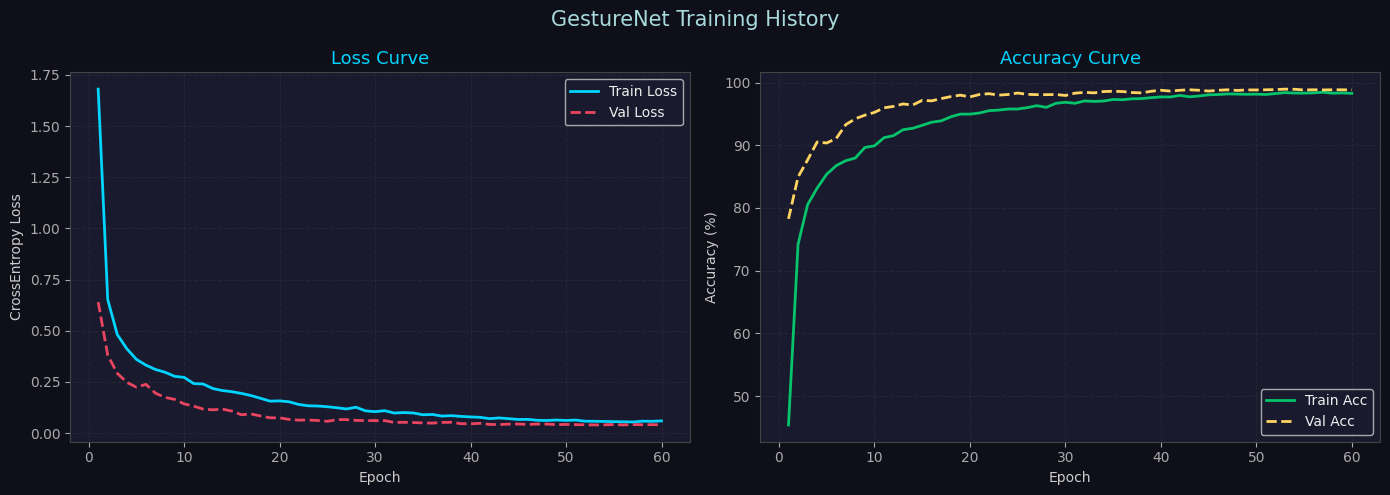

Peak Val Accuracy  : 98.96%
Final Test Accuracy: 98.60%


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
epochs_ran = range(1, len(history['train_loss']) + 1)

# ── Loss Curve ────────────────────────────────────────────────────────────────
ax = axes[0]
ax.plot(epochs_ran, history['train_loss'], color='#00d4ff', lw=2, label='Train Loss')
ax.plot(epochs_ran, history['val_loss'],   color='#e94560', lw=2, label='Val Loss', linestyle='--')
ax.set_title('Loss Curve', color='#00d4ff', fontsize=13)
ax.set_xlabel('Epoch')  ;  ax.set_ylabel('CrossEntropy Loss')
ax.legend()  ;  ax.grid(True)

# ── Accuracy Curve ────────────────────────────────────────────────────────────
ax = axes[1]
ax.plot(epochs_ran, [a*100 for a in history['train_acc']], color='#05c46b', lw=2, label='Train Acc')
ax.plot(epochs_ran, [a*100 for a in history['val_acc']],   color='#ffd460', lw=2, label='Val Acc', linestyle='--')
ax.set_title('Accuracy Curve', color='#00d4ff', fontsize=13)
ax.set_xlabel('Epoch')  ;  ax.set_ylabel('Accuracy (%)')
ax.legend()  ;  ax.grid(True)

fig.suptitle('GestureNet Training History', color='#a8dadc', fontsize=15)
plt.tight_layout()
plt.show()

print(f'Peak Val Accuracy  : {max(history["val_acc"])*100:.2f}%')
print(f'Final Test Accuracy: {test_acc*100:.2f}%')

## 🔍 8 — Evaluation: Classification Report & Confusion Matrix

In [12]:
# ── Collect all predictions on test set ───────────────────────────────────────
@torch.no_grad()
def get_predictions(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    for X_batch, y_batch in loader:
        logits = model(X_batch.to(device))
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_labels.extend(y_batch.numpy())
    return np.array(all_labels), np.array(all_preds)

y_true, y_pred = get_predictions(model, test_loader, DEVICE)

# ── Classification Report ─────────────────────────────────────────────────────
# Precision : Of all predicted as class C, how many are actually C?
# Recall    : Of all actual class C, how many did we correctly predict?
# F1-Score  : Harmonic mean of Precision and Recall — the balanced metric
print('='*65)
print('     CLASSIFICATION REPORT — GestureNet (Deep Learning)')
print('='*65)
print(classification_report(y_true, y_pred, target_names=le.classes_))
print(f'Overall Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%')

     CLASSIFICATION REPORT — GestureNet (Deep Learning)
                 precision    recall  f1-score   support

           call       0.99      0.98      0.98       226
        dislike       0.99      1.00      0.99       194
           fist       1.00      0.99      1.00       141
           four       0.98      0.99      0.99       245
           like       0.98      0.99      0.98       216
           mute       0.93      0.96      0.95       163
             ok       1.00      0.99      1.00       239
            one       0.98      0.95      0.97       189
           palm       0.96      1.00      0.98       248
          peace       1.00      0.99      1.00       216
 peace_inverted       1.00      1.00      1.00       225
           rock       1.00      0.99      0.99       219
           stop       0.99      0.96      0.97       223
  stop_inverted       0.98      1.00      0.99       235
          three       0.99      0.97      0.98       219
         three2       1.00     

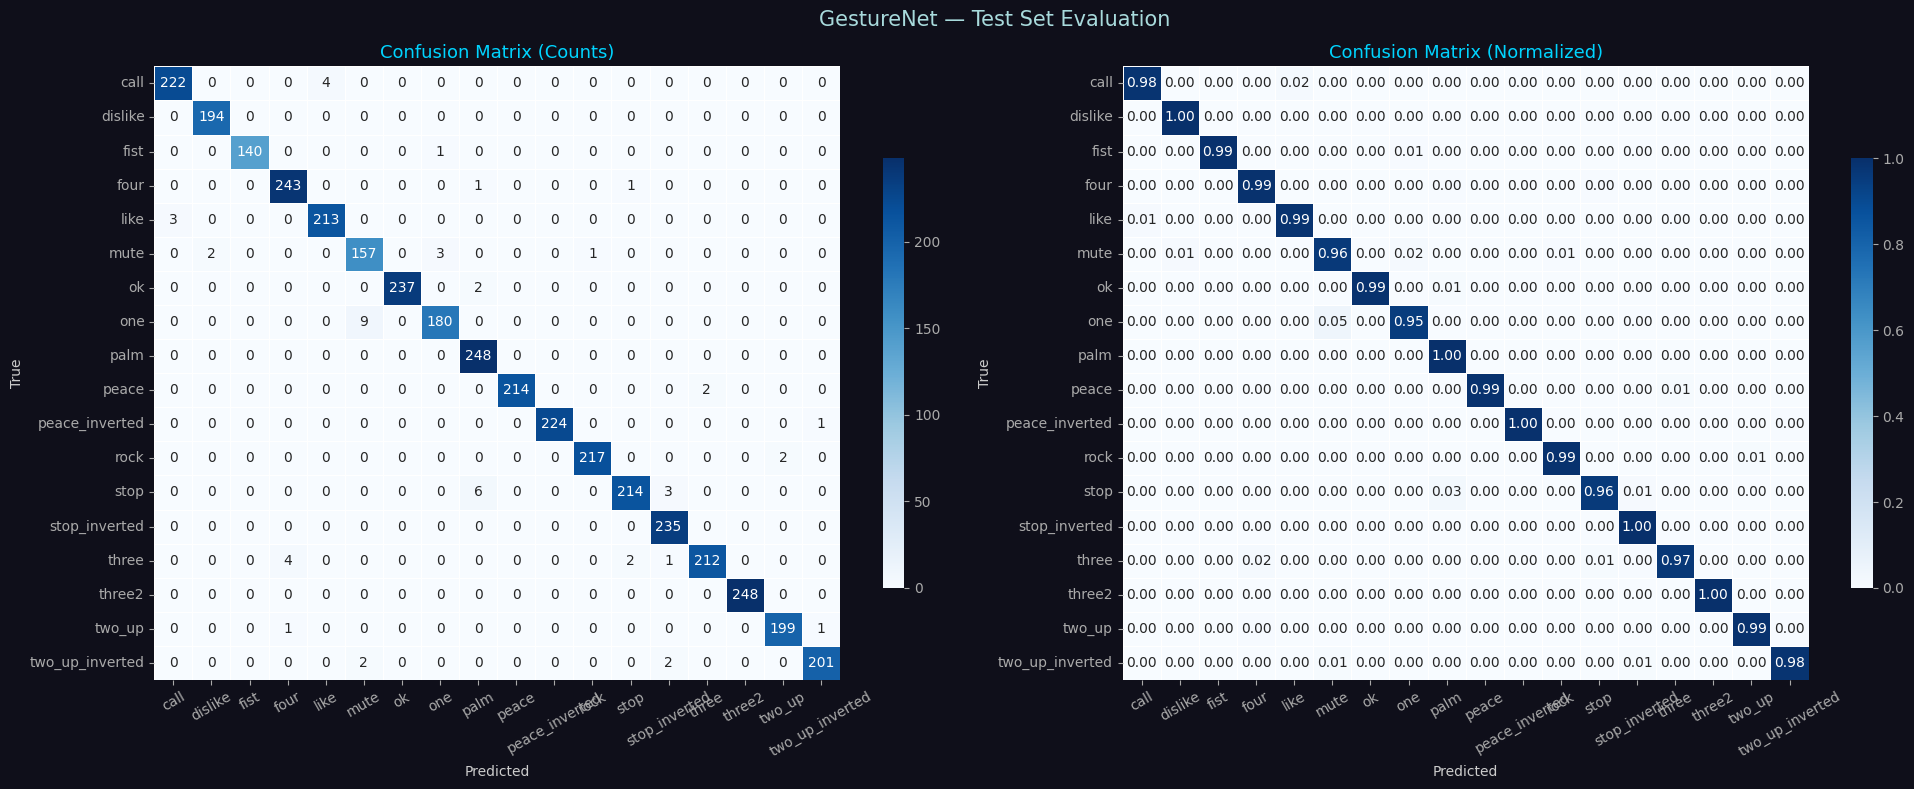

In [13]:
# ── Confusion Matrix ──────────────────────────────────────────────────────────
# Diagonal = correctly classified. Off-diagonal = misclassifications.
# Look for confused gesture PAIRS (e.g. 'peace' vs 'peace_inverted' —
# structurally similar landmarks are naturally harder to distinguish).
cm      = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

for ax, data, title, fmt in [
    (axes[0], cm,      'Confusion Matrix (Counts)',     'd'),
    (axes[1], cm_norm, 'Confusion Matrix (Normalized)', '.2f'),
]:
    sns.heatmap(data, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_,
                linewidths=0.5, ax=ax, cbar_kws={'shrink': 0.7})
    ax.set_title(title, color='#00d4ff', fontsize=13)
    ax.set_xlabel('Predicted', color='#ccc')
    ax.set_ylabel('True',      color='#ccc')
    ax.tick_params(axis='x', rotation=30)
    ax.tick_params(axis='y', rotation=0)

plt.suptitle('GestureNet — Test Set Evaluation', color='#a8dadc', fontsize=15)
plt.tight_layout()
plt.show()

## 🔬 9 — Per-Class Accuracy

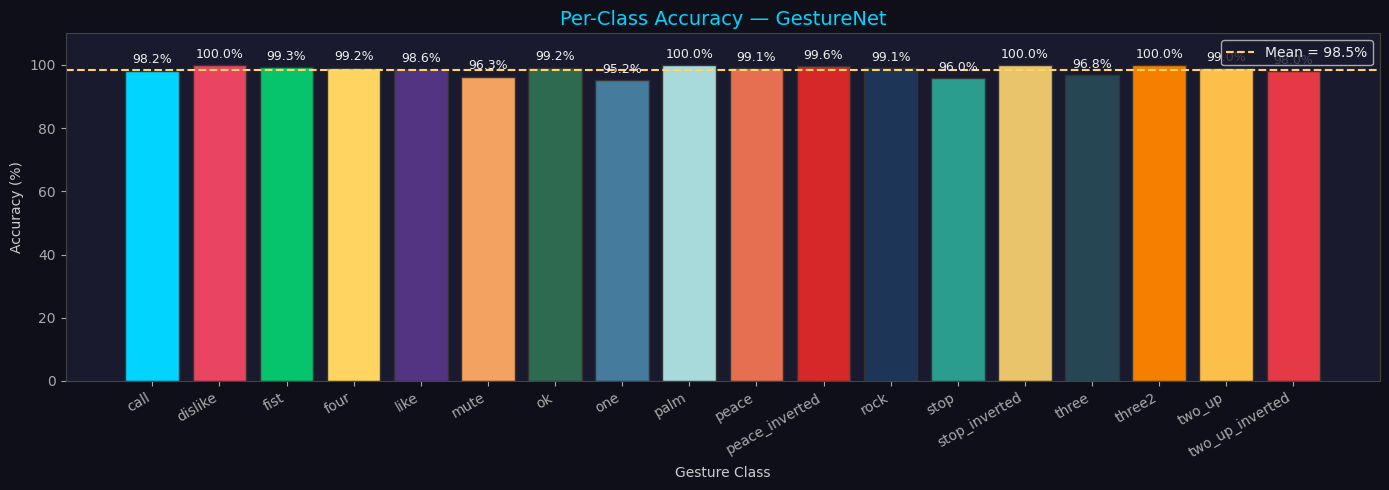

In [14]:
# ── Per-class accuracy ────────────────────────────────────────────────────────
# Reveals which gestures the network handles well vs. struggles with.
# Confusion between structurally similar gestures (e.g. three vs three2)
# is expected — they share nearly identical landmark configurations.
per_class_acc = cm.diagonal() / cm.sum(axis=1)

fig, ax = plt.subplots(figsize=(14, 5))
colors = [PALETTE[i % len(PALETTE)] for i in range(NUM_CLASSES)]
bars   = ax.bar(le.classes_, per_class_acc * 100, color=colors, edgecolor='#333')
ax.bar_label(bars, fmt='%.1f%%', padding=3, color='#eee', fontsize=9)
ax.axhline(y=np.mean(per_class_acc)*100, color='#ffd460', linestyle='--', lw=1.5,
           label=f'Mean = {np.mean(per_class_acc)*100:.1f}%')
ax.set_ylim(0, 110)
ax.set_title('Per-Class Accuracy — GestureNet', color='#00d4ff', fontsize=14)
ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Gesture Class')
ax.legend()
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

## 🔮 11 — Inference on a Single Sample

This demonstrates how a trained DL model is used in production — passing a single set of landmarks and getting a gesture prediction with confidence scores.

True Label : stop_inverted
Predicted  : stop_inverted  (confidence: 100.0%)
Correct?   : ✅ YES


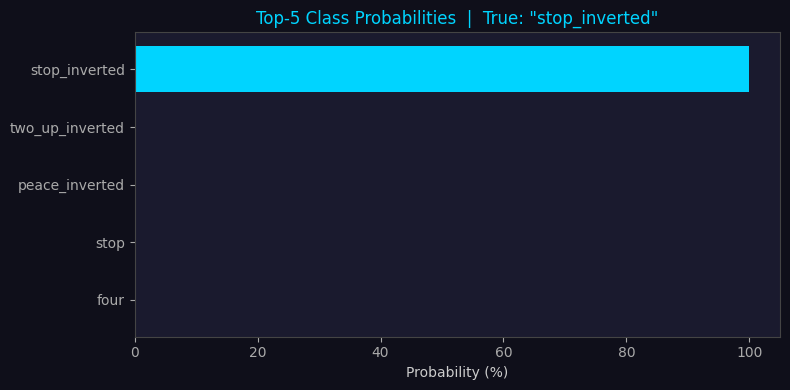

In [15]:
# ── Single-sample inference ────────────────────────────────────────────────────
# In deployment: 63 landmark values come from MediaPipe in real-time.
# Here we use a test sample to verify the full pipeline end-to-end.
sample_idx = 42
sample_raw = X_test[sample_idx : sample_idx + 1]   # shape (1, 63)
true_label = le.classes_[y_test[sample_idx]]

model.eval()
with torch.no_grad():
    sample_tensor = torch.from_numpy(sample_raw).to(DEVICE)
    logits = model(sample_tensor)

    # Convert logits → probabilities via Softmax
    # THEORY: softmax(z_i) = exp(z_i) / Σ exp(z_j)
    # All values ∈ [0,1] and sum to 1 → interpretable as class probabilities.
    probs = torch.softmax(logits, dim=1).cpu().numpy()[0]

pred_idx   = probs.argmax()
pred_label = le.classes_[pred_idx]
confidence = probs[pred_idx]

print(f'True Label : {true_label}')
print(f'Predicted  : {pred_label}  (confidence: {confidence*100:.1f}%)')
print(f'Correct?   : {"✅ YES" if true_label == pred_label else "❌ NO"}')

# ── Visualize Top-5 Class Probabilities ───────────────────────────────────────
top5_idx    = probs.argsort()[::-1][:5]
top5_labels = [le.classes_[i] for i in top5_idx]
top5_probs  = [probs[i] * 100 for i in top5_idx]

fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(top5_labels[::-1], top5_probs[::-1],
        color=['#00d4ff' if l == true_label else '#e94560' for l in top5_labels[::-1]])
ax.set_xlabel('Probability (%)')
ax.set_title(f'Top-5 Class Probabilities  |  True: "{true_label}"', color='#00d4ff')
ax.set_xlim(0, 105)
plt.tight_layout()
plt.show()

## 🧪 12 — Ablation Study: Effect of Depth & Dropout

An **ablation study** removes or changes one component at a time to understand its contribution — standard practice in DL research to justify every architecture choice.

In [16]:
class ShallowNet(nn.Module):
    """Single hidden layer — closer to Logistic Regression + one non-linearity."""
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x): return self.net(x)


class DeepNoDropout(nn.Module):
    """Same depth as GestureNet but WITHOUT Dropout — shows overfitting risk."""
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256), nn.BatchNorm1d(256), nn.ReLU(),
            nn.Linear(256, 128),       nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128, 64),        nn.BatchNorm1d(64),  nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    def forward(self, x): return self.net(x)


def quick_train(model_class, epochs=20):
    """Train a model for a few epochs and return accuracy history."""
    m    = model_class(INPUT_DIM, NUM_CLASSES).to(DEVICE)
    opt  = optim.AdamW(m.parameters(), lr=3e-3)
    crit = nn.CrossEntropyLoss()
    train_accs, val_accs = [], []
    for _ in range(epochs):
        _, tr_a = train_epoch(m, train_loader, crit, opt, DEVICE)
        _, vl_a = evaluate(m, val_loader,   crit,     DEVICE)
        train_accs.append(tr_a)
        val_accs.append(vl_a)
    return train_accs, val_accs


print('Training ablation models (20 epochs each)...')
sh_tr, sh_vl = quick_train(ShallowNet)
nd_tr, nd_vl = quick_train(DeepNoDropout)
print('✅ Done')

print(f'\nShallow (1 hidden layer) val acc : {sh_vl[-1]*100:.2f}%')
print(f'Deep (no dropout)        val acc : {nd_vl[-1]*100:.2f}%')
print(f'GestureNet (full)        val acc : {max(history["val_acc"])*100:.2f}%')
print('\n💡 Key Insight: Depth adds capacity; Dropout prevents it from overfitting.')

Training ablation models (20 epochs each)...
✅ Done

Shallow (1 hidden layer) val acc : 94.78%
Deep (no dropout)        val acc : 97.51%
GestureNet (full)        val acc : 98.96%

💡 Key Insight: Depth adds capacity; Dropout prevents it from overfitting.


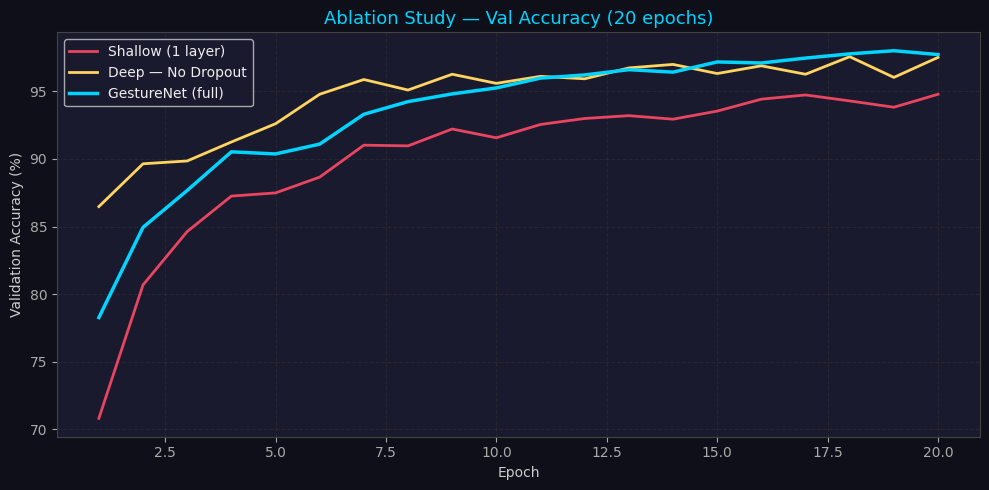

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
epochs_a = range(1, 21)

ax.plot(epochs_a, [v*100 for v in sh_vl], color='#e94560', lw=2, label='Shallow (1 layer)')
ax.plot(epochs_a, [v*100 for v in nd_vl], color='#ffd460', lw=2, label='Deep — No Dropout')
ax.plot(range(1, len(history['val_acc'][:20])+1),
        [v*100 for v in history['val_acc'][:20]],
        color='#00d4ff', lw=2.5, label='GestureNet (full)')

ax.set_title('Ablation Study — Val Accuracy (20 epochs)', color='#00d4ff', fontsize=13)
ax.set_xlabel('Epoch')  ;  ax.set_ylabel('Validation Accuracy (%)')
ax.legend()  ;  ax.grid(True)
plt.tight_layout()
plt.show()